In [22]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [23]:
"""
    load and preprocess the TCGA_PRAD dataset.

    args:
        None

    returns:
        TCGA_PRAD_filtered (pd.DataFrame): A filtered DataFrame with irrelevant columns and samples removed,
        and a `cancer_stage` column added for early (0) and late (1) cancer classification.
 """
def load_data():
    # read dataset into pandas dataframe
    TCGA_PRAD = pd.read_csv("TCGA_PRAD.csv", low_memory=False)
    
    # remove columns with all zero
    TCGA_PRAD_filtered = TCGA_PRAD.loc[:, ~(TCGA_PRAD == 0).all()]
    
    # remove samples that don't have pathological T score
    invalid_T_score = ['[Discrepancy]', '[Not Available]']
    TCGA_PRAD_filtered = TCGA_PRAD_filtered[~TCGA_PRAD_filtered["pathologic_T"].isin(invalid_T_score)].copy()
    
    # create column for cancer stage based on pathological T score
    # 0 = early cancer, 1 = late cancer
    TCGA_PRAD_filtered["cancer_stage"] = TCGA_PRAD_filtered["pathologic_T"].str[0:2].apply(
        lambda x: 0 if x == "T2" else (1 if x in ["T3", "T4"] else None)
    )
    return TCGA_PRAD_filtered

In [24]:
"""
    split the dataset into training and testing sets.

    args:
        TCGA_PRAD_filtered (pd.DataFrame): The preprocessed DataFrame containing features and targets.
        SEED (int): Random seed for reproducibility.

    returns:
        tuple: Four arrays: X_train, X_test, y_train, y_test.
"""
def split_train_test(TCGA_PRAD_filtered, SEED):
    # initialize features and targets
    X = TCGA_PRAD_filtered.iloc[:, 1:20532].dropna(axis = 1, how = 'any').values
    y = TCGA_PRAD_filtered["cancer_stage"].values

    # split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED, shuffle = True, stratify = y)
    
    return X_train, X_test, y_train, y_test

In [25]:
"""
    compare the performance of various classifiers using 10-fold cross-validation.

    args:
        X_train (ndarray): Training features.
        y_train (ndarray): Training labels.
        SEED (int): Random seed for reproducibility.

    returns:
        displays boxplots of model accuracies and prints their mean accuracies and standard deviation.
"""
def compare_classifiers(X_train, y_train, SEED):
    # initialize models
    models = {
        "KNN": KNeighborsClassifier(),
        "Decision Tree Classifier": DecisionTreeClassifier(),
        "Naive Bayes": GaussianNB(),
        "Random Forest": RandomForestClassifier(n_estimators = 100, random_state = SEED),
        "SVM": SVC(kernel = 'linear', random_state = SEED),
        "MLP Classifier": MLPClassifier(hidden_layer_sizes = (100,), random_state = SEED),
        "Logistic Regression": LogisticRegression(random_state = SEED, max_iter = 500)
    }

    # kfold split
    kf = KFold(n_splits = 10, shuffle = True, random_state = SEED)

    # perform kfold cross validation for each model
    results = []
    for model_name, model in models.items():
        cv_results = cross_val_score(model, X_train, y_train, cv = kf, scoring = 'accuracy')
        results.append(cv_results)
    
    # boxplots
    plt.boxplot(results, tick_labels=models.keys())
    plt.xticks(rotation = 90)
    plt.ylabel('Accuracy')
    plt.title('Model Comparison Using 10-Fold CV')
    plt.show()

    # print accuracy for each model
    for model_name, cv_result in zip(models.keys(), results):
        print(f"{model_name}: Mean Accuracy = {cv_result.mean():.3f}, Std = {cv_result.std():.3f}")

    return

In [26]:
"""
    train and evaluate an AdaBoost model with a Random Forest base estimator.

    args:
        X_test (ndarray): Test features.
        X_train (ndarray): Training features.
        y_train (ndarray): Training labels.
        y_test (ndarray): Test labels.
        SEED (int): Random seed for reproducibility.

    returns:
        prints the ROC AUC score and classification report for the model.
"""
def boost_random_forest(X_test, X_train, y_train, y_test, SEED):
    # initialize random forest model and adaboost
    base_estimator = RandomForestClassifier(random_state=SEED)
    ada = AdaBoostClassifier(estimator = base_estimator, n_estimators = 180, random_state = SEED)
    
    # fit ada to the training set
    ada.fit(X_train, y_train)
    
    # compute the probabilities of obtaining the positive class
    y_pred_proba = ada.predict_proba(X_test)[0:, 1]
    
    # evaluate test-set roc_auc_score
    ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # print roc_auc_score
    print('ROC AUC score: {:.2f}'.format(ada_roc_auc))
    
    y_pred_ada = (y_pred_proba >= 0.50).astype(int)
    
    # Print classification report
    print(classification_report(y_test, y_pred_ada))

    return

In [27]:
"""
    tune hyperparameters of an AdaBoost model with a Random Forest base estimator using RandomizedSearchCV.

    args:
        X_test (ndarray): Test features.
        X_train (ndarray): Training features.
        y_train (ndarray): Training labels.
        y_test (ndarray): Test labels.
        SEED (int): Random seed for reproducibility.

    returns:
        rand_search (RandomizedSearchCV): The fitted RandomizedSearchCV object with the best model.
"""
def tune_model(X_test, X_train, y_train, y_test, SEED):
    # hyperparameters selected after tuning
    param_grid = {
        "estimator__n_estimators": [100],
        "estimator__max_depth": [3],
        "estimator__min_samples_split": [15],
        "n_estimators": [100],
    }

    # initialize random forest model and adaboost
    rf = RandomForestClassifier(random_state=SEED)
    ada = AdaBoostClassifier(estimator=rf, random_state=SEED)
    
    # initialize RandomizedSearchCV to search over the hyperparameter grid
    rand_search = RandomizedSearchCV(estimator = ada, param_distributions = param_grid, 
                                      scoring='roc_auc', cv = 10, n_jobs = 2, verbose = 1)
    
    # fit RandomizedSearchCV to training data
    rand_search.fit(X_train, y_train)

    # get the best model
    best_ada = rand_search.best_estimator_
    
    # predict probabilities for the test set
    y_pred_proba = best_ada.predict_proba(X_test)[:, 1]
    
    # Cclculate ROC AUC score
    ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('ROC AUC score: {:.2f}'.format(ada_roc_auc))
    
    # convert probabilities to binary class labels
    y_pred_ada = (y_pred_proba >= 0.49).astype(int)
    
    # print classification report
    print(classification_report(y_test, y_pred_ada))

    return rand_search

In [28]:
"""
    extract the top 10 most important features from a trained model.

    args:
        rand_search (RandomizedSearchCV): The fitted RandomizedSearchCV object with the best model.
        TCGA_PRAD_filtered (pd.DataFrame): The dataset containing the gene expression data.

    returns:
        top_10_features (pd.DataFrame): A DataFrame containing the top 10 most important features and their importances.
"""
def extract_important_features(rand_search, TCGA_PRAD_filtered):
    # get important features from model
    feature_importances = rand_search.best_estimator_.feature_importances_

    # get gene names
    gene_names = TCGA_PRAD_filtered.iloc[:, 1:20532].dropna(axis = 1, how='any').columns
    
    # create df with gene names and feature importances
    feature_df = pd.DataFrame({
        'Gene': gene_names,
        'Importance': feature_importances
    })
    
    # sort df by feature importance in descending order
    feature_df_sorted = feature_df.sort_values(by = 'Importance', ascending = False)
    
    # extract top 10 most important features
    top_10_features = feature_df_sorted.head(10)
    print(top_10_features)
    return 

Comparing Classifiers...


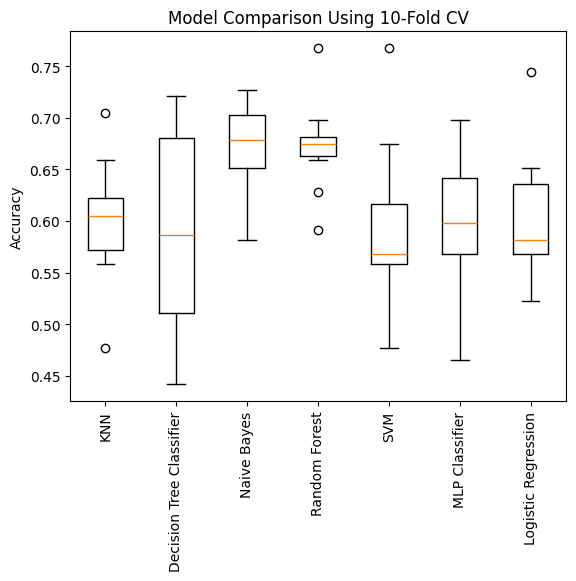

KNN: Mean Accuracy = 0.599, Std = 0.058
Decision Tree Classifier: Mean Accuracy = 0.588, Std = 0.093
Naive Bayes: Mean Accuracy = 0.670, Std = 0.044
Random Forest: Mean Accuracy = 0.673, Std = 0.043
SVM: Mean Accuracy = 0.590, Std = 0.078
MLP Classifier: Mean Accuracy = 0.597, Std = 0.061
Logistic Regression: Mean Accuracy = 0.599, Std = 0.062

Boosted Random Forest...


/usr4/bf591/rvboz/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ROC AUC score: 0.84
              precision    recall  f1-score   support

           0       0.75      0.63      0.68        43
           1       0.78      0.86      0.82        66

    accuracy                           0.77       109
   macro avg       0.77      0.75      0.75       109
weighted avg       0.77      0.77      0.77       109


Hyperparameter Tuning...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr4/bf591/rvboz/.local/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr4/bf591/rvboz/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr4/bf591/rvboz/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr4/bf591/rvboz/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warn

ROC AUC score: 0.83
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        43
           1       0.81      0.85      0.83        66

    accuracy                           0.79       109
   macro avg       0.78      0.77      0.78       109
weighted avg       0.79      0.79      0.79       109


Feature Importance...
                   Gene  Importance
14120      RNF185|91445    0.002037
3397        CDNF|441549    0.001874
822       APOBEC3B|9582    0.001724
15066         SIX3|6496    0.001506
11476        NR1I2|8856    0.001473
4224   CTAGE4|100128553    0.001463
1724    C11orf82|220042    0.001456
15772       SPAG5|10615    0.001424
10875        MYO1E|4643    0.001386
17634       UBE2C|11065    0.001384


In [29]:
'''
    run supervised classifier model evaluation, boosted random forest, hypertuning, and feature importance.
'''
def main():
    SEED = 42
    data = load_data()
    X_train, X_test, y_train, y_test = split_train_test(data, SEED)

    # compare classifiers
    print("Comparing Classifiers...")
    compare_classifiers(X_train, y_train, SEED)

    # boosted random forest
    print("\nBoosted Random Forest...")
    boost_random_forest(X_test, X_train, y_train, y_test, SEED)

    # hyperparameter tuning
    print("\nHyperparameter Tuning...")
    rand_search = tune_model(X_test, X_train, y_train, y_test, SEED)

    # feature importance
    print("\nFeature Importance...")
    extract_important_features(rand_search, data)
    
if __name__ == "__main__":
    main()